# Variational Autoencoder (VAE) to generate handwritten digits
* Author: Johannes Maucher - adapted from [keras autoencoder tutorial](https://blog.keras.io/building-autoencoders-in-keras.html).
* Last Update: 14.01.2018
* Reference: [D.P. Kingma, M. Welling: Autoencoder Variational Bayes](https://arxiv.org/abs/1312.6114)

## Autoencoder

An autoencoder consists of an encoder- and a decoder-module. The encoder maps each input $\mathbf{x}$ to a latent representation $\mathbf{y}$, such that the decoder network is able to calculate a reconstruction $\mathbf{z}$ from $\mathbf{y}$, whereby $\mathbf{z}$ must be as close as possible to the input $\mathbf{x}$. The weights of the encoder- and decoder- module are learned by minimizing a loss-function, which measures the difference between the reconstruction $\mathbf{z}$ and the original $\mathbf{x}$. For this standard gradient descent supervised learning algorithms, such as backpropagation can be applied. Even though the inputs must not be labeled (the target ist the input itself)! 

<img src="https://maucher.home.hdm-stuttgart.de/Pics/autoencoder.png" width="450" class="center">

Usually the latent representation $\mathbf{y}$ is much smaller, than the original $\mathbf{x}$ and it's reconstruction $\mathbf{z}$. Hence, the entire process realizes a standard lossy compression, such as e.g. jpeg-encoding of images.

After training of an autoencoder, all inputs, which are similar to inputs seen in the training phase, will be reconstructed well. However, inputs, which are totally different from the training-samples won't be reconstructed well.  

For example, if the autoencoder has been trained with many images from rabbits and geese, these two types of animals will be reconstructed well, but if no elephants has been in the training data, the trained network won't be able to reconstruct elephants sufficiently.

<img src="https://maucher.home.hdm-stuttgart.de/Pics/autoencoderGans.png" width="450" class="center">

## Variational Autoencoder
An autoencoder, as shortly described above, is not a generative model. It just tries to reconstruct the input, but it is not able to generate new data, e.g. new rabbit images or new geese images. This is where the **Variational Autoencoder (VAE)** comes in. A variational autoencoder is a generative model. A VAE, which has been trained with rabbit and geese-images is able to generate new rabbit- and geese images. A VAE, which has been trained with handwritten digit images is able to write new handwritten digits, etc. 

In general, if the probability distribution of one or multiple random variable(s) is known, then new samples, which arise from this distribution can be generated. For example, if the parameters *mean* and *standard-deviation* of a Gaussian-distributed random variable are known, then new samples can be generated, which correspond to this distribution. 

Based on this concept, a standard autoencoder can be modified to a generative model - the Variational Autoencoder - as follows: Instead of mapping the input $\mathbf{x}$ to a latent representation $\mathbf{y}$, the Encoder modul maps the input to a probability distribution. More concrete: A type of probability distribution (e.g. a Gaussian Normal Distribution) is presumed, and the output of the encoder are the concrete parameters of this distribution (e.g. *mean* and *standard deviation* for Gaussian distribution type). Then a concrete sample is generated from this distribution. This sample constitutes the input to the decoder.

The weights of the encoder and decoder-module are learned such that the output of the decoder is as close as possible to input - like in the case of an autoencoder, but now with the new process in the latent layer: parameter estimation and sampling.

![Variational Autoencoder](./Pics/variationalAutoencoder.png)

  

In [1]:
#!pip install keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow.compat.v1.keras.backend as K # see https://stackoverflow.com/questions/61056781/typeerror-tensor-is-unhashable-instead-use-tensor-ref-as-the-key-in-keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras import losses

In [3]:
from os import environ
environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [5]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [7]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [8]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [9]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [10]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

In [11]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [12]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50


  100/60000 [..............................] - ETA: 14:38 - loss: 544.4033

 1900/60000 [..............................] - ETA: 46s - loss: 341.3407  

 3600/60000 [>.............................] - ETA: 24s - loss: 296.1526

 5200/60000 [=>............................] - ETA: 17s - loss: 274.3534

 6700/60000 [==>...........................] - ETA: 13s - loss: 260.7890

 8200/60000 [===>..........................] - ETA: 10s - loss: 250.6114

 9700/60000 [===>..........................] - ETA: 9s - loss: 242.5490 

11300/60000 [====>.........................] - ETA: 7s - loss: 235.9688

12800/60000 [=====>........................] - ETA: 6s - loss: 230.8828

14400/60000 [======>.......................] - ETA: 6s - loss: 226.5684

16000/60000 [=======>......................] - ETA: 5s - loss: 223.0003

17600/60000 [=======>......................] - ETA: 4s - loss: 219.7143

19400/60000 [========>.....................] - ETA: 4s - loss: 216.9262

21200/60000 [=========>....................] - ETA: 3s - loss: 214.2823

23000/60000 [==========>...................] - ETA: 3s - loss: 211.9249

24800/60000 [===========>..................] - ETA: 3s - loss: 210.0150

26600/60000 [============>.................] - ETA: 2s - loss: 208.0482

28400/60000 [=============>................] - ETA: 2s - loss: 206.2267

30200/60000 [==============>...............] - ETA: 2s - loss: 204.6837

32000/60000 [===============>..............] - ETA: 2s - loss: 203.1764

33800/60000 [===============>..............] - ETA: 1s - loss: 201.8613

35600/60000 [================>.............] - ETA: 1s - loss: 200.6116

37400/60000 [=================>............] - ETA: 1s - loss: 199.5711

39100/60000 [==================>...........] - ETA: 1s - loss: 198.6203

40800/60000 [===================>..........] - ETA: 1s - loss: 197.6297

42500/60000 [====================>.........] - ETA: 1s - loss: 196.8278

44100/60000 [=====================>........] - ETA: 1s - loss: 196.0325

45600/60000 [=====================>........] - ETA: 0s - loss: 195.4602

47000/60000 [======================>.......] - ETA: 0s - loss: 194.8769

48500/60000 [=======================>......] - ETA: 0s - loss: 194.2582

50100/60000 [========================>.....] - ETA: 0s - loss: 193.6042

51800/60000 [========================>.....] - ETA: 0s - loss: 192.9513

53500/60000 [=========================>....] - ETA: 0s - loss: 192.3584

55200/60000 [==========================>...] - ETA: 0s - loss: 191.7386

56900/60000 [===========================>..] - ETA: 0s - loss: 191.2886

58600/60000 [============================>.] - ETA: 0s - loss: 190.7638

60000/60000 [==============================] - 3s 57us/sample - loss: 190.3485 - val_loss: 172.2862


Epoch 2/50
  100/60000 [..............................] - ETA: 2s - loss: 171.3108

 1700/60000 [..............................] - ETA: 1s - loss: 172.3044

/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


 3300/60000 [>.............................] - ETA: 1s - loss: 172.1374

 5000/60000 [=>............................] - ETA: 1s - loss: 172.6746

 6600/60000 [==>...........................] - ETA: 1s - loss: 172.0034

 8200/60000 [===>..........................] - ETA: 1s - loss: 172.1394

 9900/60000 [===>..........................] - ETA: 1s - loss: 172.0366

11600/60000 [====>.........................] - ETA: 1s - loss: 171.9784

13300/60000 [=====>........................] - ETA: 1s - loss: 171.8321

14900/60000 [======>.......................] - ETA: 1s - loss: 171.9456

16500/60000 [=======>......................] - ETA: 1s - loss: 171.9720

17900/60000 [=======>......................] - ETA: 1s - loss: 171.9004

18900/60000 [========>.....................] - ETA: 1s - loss: 171.8958

20200/60000 [=========>....................] - ETA: 1s - loss: 171.6730

21700/60000 [=========>....................] - ETA: 1s - loss: 171.4545

23300/60000 [==========>...................] - ETA: 1s - loss: 171.3559

24800/60000 [===========>..................] - ETA: 1s - loss: 171.3728

26300/60000 [============>.................] - ETA: 1s - loss: 171.2580

27800/60000 [============>.................] - ETA: 1s - loss: 171.2309

29300/60000 [=============>................] - ETA: 1s - loss: 171.0959

30600/60000 [==============>...............] - ETA: 0s - loss: 171.0107

31900/60000 [==============>...............] - ETA: 0s - loss: 170.9638

33200/60000 [===============>..............] - ETA: 0s - loss: 170.9104

34400/60000 [================>.............] - ETA: 0s - loss: 170.9193

35700/60000 [================>.............] - ETA: 0s - loss: 170.9091

37000/60000 [=================>............] - ETA: 0s - loss: 170.8256

38400/60000 [==================>...........] - ETA: 0s - loss: 170.7867

39800/60000 [==================>...........] - ETA: 0s - loss: 170.7145

41400/60000 [===================>..........] - ETA: 0s - loss: 170.6405

43000/60000 [====================>.........] - ETA: 0s - loss: 170.5270

44700/60000 [=====================>........] - ETA: 0s - loss: 170.4299

46400/60000 [======================>.......] - ETA: 0s - loss: 170.3634

48100/60000 [=======================>......] - ETA: 0s - loss: 170.3909

49800/60000 [=======================>......] - ETA: 0s - loss: 170.3551

51400/60000 [========================>.....] - ETA: 0s - loss: 170.3024

53000/60000 [=========================>....] - ETA: 0s - loss: 170.2504

54500/60000 [==========================>...] - ETA: 0s - loss: 170.1964

56100/60000 [===========================>..] - ETA: 0s - loss: 170.0989

57700/60000 [===========================>..] - ETA: 0s - loss: 170.0127

59300/60000 [============================>.] - ETA: 0s - loss: 169.9908

60000/60000 [==============================] - 2s 35us/sample - loss: 169.9734 - val_loss: 168.4681


Epoch 3/50
  100/60000 [..............................] - ETA: 2s - loss: 174.0243

 1800/60000 [..............................] - ETA: 1s - loss: 167.3754

 3500/60000 [>.............................] - ETA: 1s - loss: 168.2075

 5100/60000 [=>............................] - ETA: 1s - loss: 168.5258

 6700/60000 [==>...........................] - ETA: 1s - loss: 168.0305

 8300/60000 [===>..........................] - ETA: 1s - loss: 168.1507

 9800/60000 [===>..........................] - ETA: 1s - loss: 168.2194

11400/60000 [====>.........................] - ETA: 1s - loss: 167.8199

13000/60000 [=====>........................] - ETA: 1s - loss: 167.4714

14600/60000 [======>.......................] - ETA: 1s - loss: 167.5715

16300/60000 [=======>......................] - ETA: 1s - loss: 167.5399

18000/60000 [========>.....................] - ETA: 1s - loss: 167.5186

19700/60000 [========>.....................] - ETA: 1s - loss: 167.2149

21100/60000 [=========>....................] - ETA: 1s - loss: 167.2583

22500/60000 [==========>...................] - ETA: 1s - loss: 167.2724

24200/60000 [===========>..................] - ETA: 1s - loss: 167.4576

25900/60000 [===========>..................] - ETA: 1s - loss: 167.3392

27000/60000 [============>.................] - ETA: 1s - loss: 167.3654

28200/60000 [=============>................] - ETA: 1s - loss: 167.1871

29700/60000 [=============>................] - ETA: 1s - loss: 167.1406

30800/60000 [==============>...............] - ETA: 0s - loss: 167.0866

32300/60000 [===============>..............] - ETA: 0s - loss: 166.9905

33900/60000 [===============>..............] - ETA: 0s - loss: 166.9032

35500/60000 [================>.............] - ETA: 0s - loss: 166.8886

37000/60000 [=================>............] - ETA: 0s - loss: 166.9139

38500/60000 [==================>...........] - ETA: 0s - loss: 166.8534

39800/60000 [==================>...........] - ETA: 0s - loss: 166.8979

41200/60000 [===================>..........] - ETA: 0s - loss: 166.8301

42500/60000 [====================>.........] - ETA: 0s - loss: 166.8762

43800/60000 [====================>.........] - ETA: 0s - loss: 166.9167

45200/60000 [=====================>........] - ETA: 0s - loss: 166.9248

46600/60000 [======================>.......] - ETA: 0s - loss: 166.8909

48200/60000 [=======================>......] - ETA: 0s - loss: 166.8627

49700/60000 [=======================>......] - ETA: 0s - loss: 166.8910

51100/60000 [========================>.....] - ETA: 0s - loss: 166.8500

52400/60000 [=========================>....] - ETA: 0s - loss: 166.8268

53700/60000 [=========================>....] - ETA: 0s - loss: 166.8058

54900/60000 [==========================>...] - ETA: 0s - loss: 166.7782

56300/60000 [===========================>..] - ETA: 0s - loss: 166.7570

57700/60000 [===========================>..] - ETA: 0s - loss: 166.7647

59300/60000 [============================>.] - ETA: 0s - loss: 166.7128

60000/60000 [==============================] - 2s 36us/sample - loss: 166.7319 - val_loss: 165.5260


Epoch 4/50
  100/60000 [..............................] - ETA: 2s - loss: 138.6714

 1700/60000 [..............................] - ETA: 1s - loss: 163.5757

 3400/60000 [>.............................] - ETA: 1s - loss: 164.4797

 5200/60000 [=>............................] - ETA: 1s - loss: 164.4311

 6900/60000 [==>...........................] - ETA: 1s - loss: 164.4615

 8600/60000 [===>..........................] - ETA: 1s - loss: 164.3146

10300/60000 [====>.........................] - ETA: 1s - loss: 164.8649

12000/60000 [=====>........................] - ETA: 1s - loss: 165.1057

13500/60000 [=====>........................] - ETA: 1s - loss: 165.2133

15000/60000 [======>.......................] - ETA: 1s - loss: 165.2644

16500/60000 [=======>......................] - ETA: 1s - loss: 165.2605

18000/60000 [========>.....................] - ETA: 1s - loss: 165.1865

19500/60000 [========>.....................] - ETA: 1s - loss: 165.1707

21200/60000 [=========>....................] - ETA: 1s - loss: 165.2991

22900/60000 [==========>...................] - ETA: 1s - loss: 165.3037

24400/60000 [===========>..................] - ETA: 1s - loss: 165.2705

26000/60000 [============>.................] - ETA: 1s - loss: 165.1930

27600/60000 [============>.................] - ETA: 1s - loss: 165.1439

29100/60000 [=============>................] - ETA: 1s - loss: 165.1432

30700/60000 [==============>...............] - ETA: 0s - loss: 165.1190

32200/60000 [===============>..............] - ETA: 0s - loss: 165.0726

33800/60000 [===============>..............] - ETA: 0s - loss: 164.9759

35200/60000 [================>.............] - ETA: 0s - loss: 164.9397

36700/60000 [=================>............] - ETA: 0s - loss: 164.8594

38300/60000 [==================>...........] - ETA: 0s - loss: 164.8955

39800/60000 [==================>...........] - ETA: 0s - loss: 164.8610

41300/60000 [===================>..........] - ETA: 0s - loss: 164.8588

42800/60000 [====================>.........] - ETA: 0s - loss: 164.8503

44300/60000 [=====================>........] - ETA: 0s - loss: 164.8575

45900/60000 [=====================>........] - ETA: 0s - loss: 164.8975

47400/60000 [======================>.......] - ETA: 0s - loss: 164.8549

49000/60000 [=======================>......] - ETA: 0s - loss: 164.8596

50500/60000 [========================>.....] - ETA: 0s - loss: 164.8189

52100/60000 [=========================>....] - ETA: 0s - loss: 164.7677

53700/60000 [=========================>....] - ETA: 0s - loss: 164.7357

55300/60000 [==========================>...] - ETA: 0s - loss: 164.7379

56900/60000 [===========================>..] - ETA: 0s - loss: 164.7182

58500/60000 [============================>.] - ETA: 0s - loss: 164.7029

60000/60000 [==============================] - 2s 34us/sample - loss: 164.6650 - val_loss: 164.2411


Epoch 5/50
  100/60000 [..............................] - ETA: 2s - loss: 163.9541

 1800/60000 [..............................] - ETA: 1s - loss: 162.5029

 3500/60000 [>.............................] - ETA: 1s - loss: 163.1340

 5200/60000 [=>............................] - ETA: 1s - loss: 163.2548

 6800/60000 [==>...........................] - ETA: 1s - loss: 163.7708

 8300/60000 [===>..........................] - ETA: 1s - loss: 163.5769

 9900/60000 [===>..........................] - ETA: 1s - loss: 163.7918

11600/60000 [====>.........................] - ETA: 1s - loss: 163.8191

13200/60000 [=====>........................] - ETA: 1s - loss: 163.9106

14800/60000 [======>.......................] - ETA: 1s - loss: 163.7289

16400/60000 [=======>......................] - ETA: 1s - loss: 163.8420

18100/60000 [========>.....................] - ETA: 1s - loss: 163.7958

19700/60000 [========>.....................] - ETA: 1s - loss: 163.7716

21500/60000 [=========>....................] - ETA: 1s - loss: 163.6123

23300/60000 [==========>...................] - ETA: 1s - loss: 163.5853

24900/60000 [===========>..................] - ETA: 1s - loss: 163.4927

26600/60000 [============>.................] - ETA: 1s - loss: 163.5073

28300/60000 [=============>................] - ETA: 0s - loss: 163.4143

30000/60000 [==============>...............] - ETA: 0s - loss: 163.3674

31700/60000 [==============>...............] - ETA: 0s - loss: 163.2986

33400/60000 [===============>..............] - ETA: 0s - loss: 163.2499

35200/60000 [================>.............] - ETA: 0s - loss: 163.2777

37000/60000 [=================>............] - ETA: 0s - loss: 163.3129

38800/60000 [==================>...........] - ETA: 0s - loss: 163.3255

40600/60000 [===================>..........] - ETA: 0s - loss: 163.3284

42400/60000 [====================>.........] - ETA: 0s - loss: 163.3174

44200/60000 [=====================>........] - ETA: 0s - loss: 163.2525

46000/60000 [======================>.......] - ETA: 0s - loss: 163.2728

47700/60000 [======================>.......] - ETA: 0s - loss: 163.1882

49300/60000 [=======================>......] - ETA: 0s - loss: 163.1923

51000/60000 [========================>.....] - ETA: 0s - loss: 163.1920

52700/60000 [=========================>....] - ETA: 0s - loss: 163.1736

54400/60000 [==========================>...] - ETA: 0s - loss: 163.1706

56100/60000 [===========================>..] - ETA: 0s - loss: 163.1896

57800/60000 [===========================>..] - ETA: 0s - loss: 163.2324

59500/60000 [============================>.] - ETA: 0s - loss: 163.2065

60000/60000 [==============================] - 2s 32us/sample - loss: 163.2293 - val_loss: 162.8177


Epoch 6/50
  100/60000 [..............................] - ETA: 2s - loss: 168.8177

 1800/60000 [..............................] - ETA: 1s - loss: 162.9143

 3500/60000 [>.............................] - ETA: 1s - loss: 161.9300

 5300/60000 [=>............................] - ETA: 1s - loss: 162.0653

 7100/60000 [==>...........................] - ETA: 1s - loss: 162.0547

 8900/60000 [===>..........................] - ETA: 1s - loss: 162.2657

10700/60000 [====>.........................] - ETA: 1s - loss: 162.3619

12500/60000 [=====>........................] - ETA: 1s - loss: 162.5139

14300/60000 [======>.......................] - ETA: 1s - loss: 162.5748

16100/60000 [=======>......................] - ETA: 1s - loss: 162.4907

17900/60000 [=======>......................] - ETA: 1s - loss: 162.3442

19600/60000 [========>.....................] - ETA: 1s - loss: 162.4704

21300/60000 [=========>....................] - ETA: 1s - loss: 162.4120

23100/60000 [==========>...................] - ETA: 1s - loss: 162.5276

24900/60000 [===========>..................] - ETA: 1s - loss: 162.6028

26700/60000 [============>.................] - ETA: 0s - loss: 162.6232

28500/60000 [=============>................] - ETA: 0s - loss: 162.6183

30300/60000 [==============>...............] - ETA: 0s - loss: 162.5791

32000/60000 [===============>..............] - ETA: 0s - loss: 162.5566

33800/60000 [===============>..............] - ETA: 0s - loss: 162.5101

35600/60000 [================>.............] - ETA: 0s - loss: 162.4317

37200/60000 [=================>............] - ETA: 0s - loss: 162.4110

38800/60000 [==================>...........] - ETA: 0s - loss: 162.3429

40200/60000 [===================>..........] - ETA: 0s - loss: 162.3043

41700/60000 [===================>..........] - ETA: 0s - loss: 162.2658

43100/60000 [====================>.........] - ETA: 0s - loss: 162.2547

44400/60000 [=====================>........] - ETA: 0s - loss: 162.1877

46000/60000 [======================>.......] - ETA: 0s - loss: 162.1576

47600/60000 [======================>.......] - ETA: 0s - loss: 162.1470

49200/60000 [=======================>......] - ETA: 0s - loss: 162.1793

50800/60000 [========================>.....] - ETA: 0s - loss: 162.1290

52300/60000 [=========================>....] - ETA: 0s - loss: 162.0897

53900/60000 [=========================>....] - ETA: 0s - loss: 162.1022

55500/60000 [==========================>...] - ETA: 0s - loss: 162.0454

57200/60000 [===========================>..] - ETA: 0s - loss: 162.0608

58900/60000 [============================>.] - ETA: 0s - loss: 162.0774

60000/60000 [==============================] - 2s 32us/sample - loss: 162.0725 - val_loss: 161.9751


Epoch 7/50
  100/60000 [..............................] - ETA: 3s - loss: 151.2881

 1500/60000 [..............................] - ETA: 2s - loss: 161.5236

 2900/60000 [>.............................] - ETA: 2s - loss: 161.0774

 4400/60000 [=>............................] - ETA: 2s - loss: 160.9006

 6000/60000 [==>...........................] - ETA: 1s - loss: 160.7006

 7600/60000 [==>...........................] - ETA: 1s - loss: 160.4914

 9200/60000 [===>..........................] - ETA: 1s - loss: 160.5920

10800/60000 [====>.........................] - ETA: 1s - loss: 160.5591

12400/60000 [=====>........................] - ETA: 1s - loss: 160.5339

13900/60000 [=====>........................] - ETA: 1s - loss: 160.5687

15400/60000 [======>.......................] - ETA: 1s - loss: 160.6637

17000/60000 [=======>......................] - ETA: 1s - loss: 160.7270

18600/60000 [========>.....................] - ETA: 1s - loss: 160.8549

20100/60000 [=========>....................] - ETA: 1s - loss: 161.0297

21600/60000 [=========>....................] - ETA: 1s - loss: 161.0626

23100/60000 [==========>...................] - ETA: 1s - loss: 161.1277

24800/60000 [===========>..................] - ETA: 1s - loss: 161.1475

26500/60000 [============>.................] - ETA: 1s - loss: 161.0560

28100/60000 [=============>................] - ETA: 1s - loss: 161.0860

29800/60000 [=============>................] - ETA: 1s - loss: 161.1696

31500/60000 [==============>...............] - ETA: 0s - loss: 161.2206

33200/60000 [===============>..............] - ETA: 0s - loss: 161.0399

35000/60000 [================>.............] - ETA: 0s - loss: 161.0272

36800/60000 [=================>............] - ETA: 0s - loss: 161.1174

38300/60000 [==================>...........] - ETA: 0s - loss: 161.1298

39800/60000 [==================>...........] - ETA: 0s - loss: 161.1394

41300/60000 [===================>..........] - ETA: 0s - loss: 161.1359

42800/60000 [====================>.........] - ETA: 0s - loss: 161.1570

44300/60000 [=====================>........] - ETA: 0s - loss: 161.1844

45800/60000 [=====================>........] - ETA: 0s - loss: 161.1518

47200/60000 [======================>.......] - ETA: 0s - loss: 161.1384

48700/60000 [=======================>......] - ETA: 0s - loss: 161.1294

50400/60000 [========================>.....] - ETA: 0s - loss: 161.1539

52200/60000 [=========================>....] - ETA: 0s - loss: 161.1523

53500/60000 [=========================>....] - ETA: 0s - loss: 161.1324

54900/60000 [==========================>...] - ETA: 0s - loss: 161.1415

56500/60000 [===========================>..] - ETA: 0s - loss: 161.1295

58200/60000 [============================>.] - ETA: 0s - loss: 161.1304

59900/60000 [============================>.] - ETA: 0s - loss: 161.0710

60000/60000 [==============================] - 2s 35us/sample - loss: 161.0749 - val_loss: 161.0978


Epoch 8/50
  100/60000 [..............................] - ETA: 3s - loss: 159.4165

 1500/60000 [..............................] - ETA: 2s - loss: 162.4497

 3200/60000 [>.............................] - ETA: 1s - loss: 161.8954

 4800/60000 [=>............................] - ETA: 1s - loss: 160.7981

 6400/60000 [==>...........................] - ETA: 1s - loss: 160.6038

 8000/60000 [===>..........................] - ETA: 1s - loss: 160.3283

 9700/60000 [===>..........................] - ETA: 1s - loss: 160.0851

11400/60000 [====>.........................] - ETA: 1s - loss: 160.0918

13000/60000 [=====>........................] - ETA: 1s - loss: 159.8645

14400/60000 [======>.......................] - ETA: 1s - loss: 159.7557

15400/60000 [======>.......................] - ETA: 1s - loss: 159.7663

16900/60000 [=======>......................] - ETA: 1s - loss: 159.8642

18500/60000 [========>.....................] - ETA: 1s - loss: 159.9488

19900/60000 [========>.....................] - ETA: 1s - loss: 159.9783

21400/60000 [=========>....................] - ETA: 1s - loss: 159.8431

22900/60000 [==========>...................] - ETA: 1s - loss: 159.8808

24400/60000 [===========>..................] - ETA: 1s - loss: 159.8972

26100/60000 [============>.................] - ETA: 1s - loss: 159.7758

27700/60000 [============>.................] - ETA: 1s - loss: 159.8730

29300/60000 [=============>................] - ETA: 1s - loss: 159.9314

30900/60000 [==============>...............] - ETA: 0s - loss: 159.9563

32500/60000 [===============>..............] - ETA: 0s - loss: 160.0307

34200/60000 [================>.............] - ETA: 0s - loss: 160.0251

35900/60000 [================>.............] - ETA: 0s - loss: 160.0795

37600/60000 [=================>............] - ETA: 0s - loss: 160.0907

39300/60000 [==================>...........] - ETA: 0s - loss: 160.0652

40900/60000 [===================>..........] - ETA: 0s - loss: 160.0798

42400/60000 [====================>.........] - ETA: 0s - loss: 160.0440

43900/60000 [====================>.........] - ETA: 0s - loss: 159.9527

45500/60000 [=====================>........] - ETA: 0s - loss: 159.9843

47000/60000 [======================>.......] - ETA: 0s - loss: 160.0684

48500/60000 [=======================>......] - ETA: 0s - loss: 160.0575

49900/60000 [=======================>......] - ETA: 0s - loss: 160.1036

51400/60000 [========================>.....] - ETA: 0s - loss: 160.1197

53000/60000 [=========================>....] - ETA: 0s - loss: 160.1689

54600/60000 [==========================>...] - ETA: 0s - loss: 160.1943

56200/60000 [===========================>..] - ETA: 0s - loss: 160.1507

57800/60000 [===========================>..] - ETA: 0s - loss: 160.1426

59500/60000 [============================>.] - ETA: 0s - loss: 160.1234

60000/60000 [==============================] - 2s 34us/sample - loss: 160.1259 - val_loss: 159.7975


Epoch 9/50
  100/60000 [..............................] - ETA: 2s - loss: 156.1220

 1800/60000 [..............................] - ETA: 1s - loss: 160.8060

 3500/60000 [>.............................] - ETA: 1s - loss: 160.5535

 5200/60000 [=>............................] - ETA: 1s - loss: 160.1738

 6900/60000 [==>...........................] - ETA: 1s - loss: 159.5297

 8600/60000 [===>..........................] - ETA: 1s - loss: 159.3208

10100/60000 [====>.........................] - ETA: 1s - loss: 159.2372

11200/60000 [====>.........................] - ETA: 1s - loss: 159.1793

12100/60000 [=====>........................] - ETA: 1s - loss: 159.0834

13400/60000 [=====>........................] - ETA: 1s - loss: 159.2118

14900/60000 [======>.......................] - ETA: 1s - loss: 159.2696

16400/60000 [=======>......................] - ETA: 1s - loss: 159.3389

17700/60000 [=======>......................] - ETA: 1s - loss: 159.4805

19000/60000 [========>.....................] - ETA: 1s - loss: 159.4210

20100/60000 [=========>....................] - ETA: 1s - loss: 159.4074

21500/60000 [=========>....................] - ETA: 1s - loss: 159.3826

22800/60000 [==========>...................] - ETA: 1s - loss: 159.3411

23900/60000 [==========>...................] - ETA: 1s - loss: 159.3977

25400/60000 [===========>..................] - ETA: 1s - loss: 159.4806

26900/60000 [============>.................] - ETA: 1s - loss: 159.4974

28500/60000 [=============>................] - ETA: 1s - loss: 159.6069

30000/60000 [==============>...............] - ETA: 1s - loss: 159.5712

31600/60000 [==============>...............] - ETA: 1s - loss: 159.5939

33000/60000 [===============>..............] - ETA: 0s - loss: 159.6205

34100/60000 [================>.............] - ETA: 0s - loss: 159.5206

35300/60000 [================>.............] - ETA: 0s - loss: 159.5244

36500/60000 [=================>............] - ETA: 0s - loss: 159.5478

37900/60000 [=================>............] - ETA: 0s - loss: 159.4538

39400/60000 [==================>...........] - ETA: 0s - loss: 159.4116

40700/60000 [===================>..........] - ETA: 0s - loss: 159.4216

42300/60000 [====================>.........] - ETA: 0s - loss: 159.3932

43800/60000 [====================>.........] - ETA: 0s - loss: 159.4043

45400/60000 [=====================>........] - ETA: 0s - loss: 159.4487

47000/60000 [======================>.......] - ETA: 0s - loss: 159.4092

48600/60000 [=======================>......] - ETA: 0s - loss: 159.4091

50300/60000 [========================>.....] - ETA: 0s - loss: 159.2790

52000/60000 [=========================>....] - ETA: 0s - loss: 159.2879

53600/60000 [=========================>....] - ETA: 0s - loss: 159.3219

55200/60000 [==========================>...] - ETA: 0s - loss: 159.2810

56700/60000 [===========================>..] - ETA: 0s - loss: 159.2408

58300/60000 [============================>.] - ETA: 0s - loss: 159.2474

59800/60000 [============================>.] - ETA: 0s - loss: 159.2381

60000/60000 [==============================] - 2s 37us/sample - loss: 159.2422 - val_loss: 159.0891


Epoch 10/50
  100/60000 [..............................] - ETA: 2s - loss: 167.7328

 1700/60000 [..............................] - ETA: 1s - loss: 157.9657

 3300/60000 [>.............................] - ETA: 1s - loss: 157.3806

 4900/60000 [=>............................] - ETA: 1s - loss: 157.5761

 6600/60000 [==>...........................] - ETA: 1s - loss: 158.2178

 8300/60000 [===>..........................] - ETA: 1s - loss: 157.9227

10000/60000 [====>.........................] - ETA: 1s - loss: 158.0819

11500/60000 [====>.........................] - ETA: 1s - loss: 158.3166

13000/60000 [=====>........................] - ETA: 1s - loss: 158.7076

14300/60000 [======>.......................] - ETA: 1s - loss: 158.5505

15800/60000 [======>.......................] - ETA: 1s - loss: 158.6748

17500/60000 [=======>......................] - ETA: 1s - loss: 158.8030

19300/60000 [========>.....................] - ETA: 1s - loss: 158.7535

20900/60000 [=========>....................] - ETA: 1s - loss: 158.6708

22700/60000 [==========>...................] - ETA: 1s - loss: 158.6065

24400/60000 [===========>..................] - ETA: 1s - loss: 158.5555

26000/60000 [============>.................] - ETA: 1s - loss: 158.5282

27700/60000 [============>.................] - ETA: 1s - loss: 158.5703

29300/60000 [=============>................] - ETA: 0s - loss: 158.4678

30900/60000 [==============>...............] - ETA: 0s - loss: 158.4827

32600/60000 [===============>..............] - ETA: 0s - loss: 158.4115

34300/60000 [================>.............] - ETA: 0s - loss: 158.4388

36100/60000 [=================>............] - ETA: 0s - loss: 158.3978

37900/60000 [=================>............] - ETA: 0s - loss: 158.4936

39600/60000 [==================>...........] - ETA: 0s - loss: 158.5481

41300/60000 [===================>..........] - ETA: 0s - loss: 158.5884

43000/60000 [====================>.........] - ETA: 0s - loss: 158.5394

44700/60000 [=====================>........] - ETA: 0s - loss: 158.4785

46500/60000 [======================>.......] - ETA: 0s - loss: 158.4261

48300/60000 [=======================>......] - ETA: 0s - loss: 158.4176

50000/60000 [========================>.....] - ETA: 0s - loss: 158.3887

51700/60000 [========================>.....] - ETA: 0s - loss: 158.4569

53400/60000 [=========================>....] - ETA: 0s - loss: 158.4023

55100/60000 [==========================>...] - ETA: 0s - loss: 158.3990

56800/60000 [===========================>..] - ETA: 0s - loss: 158.3349

58500/60000 [============================>.] - ETA: 0s - loss: 158.3813

60000/60000 [==============================] - 2s 32us/sample - loss: 158.4482 - val_loss: 158.6570


Epoch 11/50
  100/60000 [..............................] - ETA: 2s - loss: 156.3414

 1900/60000 [..............................] - ETA: 1s - loss: 158.0854

 3700/60000 [>.............................] - ETA: 1s - loss: 157.9339

 5400/60000 [=>............................] - ETA: 1s - loss: 157.8018

 7000/60000 [==>...........................] - ETA: 1s - loss: 157.6933

 8600/60000 [===>..........................] - ETA: 1s - loss: 157.8919

10000/60000 [====>.........................] - ETA: 1s - loss: 158.0701

11500/60000 [====>.........................] - ETA: 1s - loss: 157.7521

13000/60000 [=====>........................] - ETA: 1s - loss: 157.9995

14500/60000 [======>.......................] - ETA: 1s - loss: 157.8461

15900/60000 [======>.......................] - ETA: 1s - loss: 157.9412

17400/60000 [=======>......................] - ETA: 1s - loss: 157.8769

19000/60000 [========>.....................] - ETA: 1s - loss: 158.0371

20500/60000 [=========>....................] - ETA: 1s - loss: 157.9691

21900/60000 [=========>....................] - ETA: 1s - loss: 158.0145

23400/60000 [==========>...................] - ETA: 1s - loss: 158.0919

24900/60000 [===========>..................] - ETA: 1s - loss: 158.0348

26500/60000 [============>.................] - ETA: 1s - loss: 158.0115

28100/60000 [=============>................] - ETA: 1s - loss: 157.9299

29800/60000 [=============>................] - ETA: 1s - loss: 157.8454

31500/60000 [==============>...............] - ETA: 0s - loss: 157.8622

33100/60000 [===============>..............] - ETA: 0s - loss: 157.8455

34200/60000 [================>.............] - ETA: 0s - loss: 157.8771

35000/60000 [================>.............] - ETA: 0s - loss: 157.8741

36100/60000 [=================>............] - ETA: 0s - loss: 157.8488

37000/60000 [=================>............] - ETA: 0s - loss: 157.8084

38200/60000 [==================>...........] - ETA: 0s - loss: 157.8835

39500/60000 [==================>...........] - ETA: 0s - loss: 157.8527

40700/60000 [===================>..........] - ETA: 0s - loss: 157.8412

42200/60000 [====================>.........] - ETA: 0s - loss: 157.7949

43900/60000 [====================>.........] - ETA: 0s - loss: 157.8007

45600/60000 [=====================>........] - ETA: 0s - loss: 157.7801

47200/60000 [======================>.......] - ETA: 0s - loss: 157.8140

48800/60000 [=======================>......] - ETA: 0s - loss: 157.8026

50300/60000 [========================>.....] - ETA: 0s - loss: 157.7534

52000/60000 [=========================>....] - ETA: 0s - loss: 157.7703

53600/60000 [=========================>....] - ETA: 0s - loss: 157.7822

55100/60000 [==========================>...] - ETA: 0s - loss: 157.7352

56800/60000 [===========================>..] - ETA: 0s - loss: 157.7137

58400/60000 [============================>.] - ETA: 0s - loss: 157.7167

60000/60000 [==============================] - ETA: 0s - loss: 157.7422

60000/60000 [==============================] - 2s 36us/sample - loss: 157.7422 - val_loss: 157.8895


Epoch 12/50
  100/60000 [..............................] - ETA: 2s - loss: 165.7567

 1600/60000 [..............................] - ETA: 2s - loss: 156.0360

 3200/60000 [>.............................] - ETA: 1s - loss: 156.0877

 4600/60000 [=>............................] - ETA: 1s - loss: 157.3991

 6000/60000 [==>...........................] - ETA: 1s - loss: 157.7540

 7400/60000 [==>...........................] - ETA: 1s - loss: 157.6008

 9000/60000 [===>..........................] - ETA: 1s - loss: 157.5396

10800/60000 [====>.........................] - ETA: 1s - loss: 157.4298

12600/60000 [=====>........................] - ETA: 1s - loss: 157.2501

14000/60000 [======>.......................] - ETA: 1s - loss: 157.2271

15200/60000 [======>.......................] - ETA: 1s - loss: 157.2360

16500/60000 [=======>......................] - ETA: 1s - loss: 157.2789

17800/60000 [=======>......................] - ETA: 1s - loss: 157.3095

19000/60000 [========>.....................] - ETA: 1s - loss: 157.4027

20000/60000 [=========>....................] - ETA: 1s - loss: 157.2692

21000/60000 [=========>....................] - ETA: 1s - loss: 157.3620

22200/60000 [==========>...................] - ETA: 1s - loss: 157.2064

23000/60000 [==========>...................] - ETA: 1s - loss: 157.2074

24300/60000 [===========>..................] - ETA: 1s - loss: 157.0544

25500/60000 [===========>..................] - ETA: 1s - loss: 156.9681

26700/60000 [============>.................] - ETA: 1s - loss: 157.0152

28000/60000 [=============>................] - ETA: 1s - loss: 157.0799

29400/60000 [=============>................] - ETA: 1s - loss: 157.1184

30600/60000 [==============>...............] - ETA: 1s - loss: 157.0343

31700/60000 [==============>...............] - ETA: 1s - loss: 156.9966

32800/60000 [===============>..............] - ETA: 1s - loss: 156.9331

34000/60000 [================>.............] - ETA: 1s - loss: 156.9840

35100/60000 [================>.............] - ETA: 0s - loss: 156.9968

36300/60000 [=================>............] - ETA: 0s - loss: 156.9871

37400/60000 [=================>............] - ETA: 0s - loss: 156.9747

38500/60000 [==================>...........] - ETA: 0s - loss: 156.9960

39500/60000 [==================>...........] - ETA: 0s - loss: 156.9929

40800/60000 [===================>..........] - ETA: 0s - loss: 157.0208

42100/60000 [====================>.........] - ETA: 0s - loss: 157.0415

43300/60000 [====================>.........] - ETA: 0s - loss: 157.0798

44500/60000 [=====================>........] - ETA: 0s - loss: 157.1048

45800/60000 [=====================>........] - ETA: 0s - loss: 157.0840

47100/60000 [======================>.......] - ETA: 0s - loss: 157.0876

48400/60000 [=======================>......] - ETA: 0s - loss: 157.0937

49700/60000 [=======================>......] - ETA: 0s - loss: 157.1330

51000/60000 [========================>.....] - ETA: 0s - loss: 157.1602

52600/60000 [=========================>....] - ETA: 0s - loss: 157.1417

54400/60000 [==========================>...] - ETA: 0s - loss: 157.1229

56200/60000 [===========================>..] - ETA: 0s - loss: 157.1574

58000/60000 [============================>.] - ETA: 0s - loss: 157.1658

59800/60000 [============================>.] - ETA: 0s - loss: 157.1280

60000/60000 [==============================] - 2s 41us/sample - loss: 157.1190 - val_loss: 157.4449


Epoch 13/50
  100/60000 [..............................] - ETA: 2s - loss: 155.2831

 1900/60000 [..............................] - ETA: 1s - loss: 156.3579

 3600/60000 [>.............................] - ETA: 1s - loss: 156.3337

 5400/60000 [=>............................] - ETA: 1s - loss: 156.5917

 7200/60000 [==>...........................] - ETA: 1s - loss: 156.6620

 9000/60000 [===>..........................] - ETA: 1s - loss: 156.4025

10800/60000 [====>.........................] - ETA: 1s - loss: 156.6160

12400/60000 [=====>........................] - ETA: 1s - loss: 156.6120

14200/60000 [======>.......................] - ETA: 1s - loss: 156.6337

15800/60000 [======>.......................] - ETA: 1s - loss: 156.5792

17400/60000 [=======>......................] - ETA: 1s - loss: 156.6325

19100/60000 [========>.....................] - ETA: 1s - loss: 156.5460

20800/60000 [=========>....................] - ETA: 1s - loss: 156.6709

22500/60000 [==========>...................] - ETA: 1s - loss: 156.6259

24300/60000 [===========>..................] - ETA: 1s - loss: 156.6205

25800/60000 [===========>..................] - ETA: 1s - loss: 156.6606

27400/60000 [============>.................] - ETA: 0s - loss: 156.6304

28900/60000 [=============>................] - ETA: 0s - loss: 156.6962

30500/60000 [==============>...............] - ETA: 0s - loss: 156.6715

32100/60000 [===============>..............] - ETA: 0s - loss: 156.6379

33700/60000 [===============>..............] - ETA: 0s - loss: 156.6061

35300/60000 [================>.............] - ETA: 0s - loss: 156.7933

37000/60000 [=================>............] - ETA: 0s - loss: 156.7475

38700/60000 [==================>...........] - ETA: 0s - loss: 156.6820

40300/60000 [===================>..........] - ETA: 0s - loss: 156.6802

42000/60000 [====================>.........] - ETA: 0s - loss: 156.6802

43600/60000 [====================>.........] - ETA: 0s - loss: 156.7461

45200/60000 [=====================>........] - ETA: 0s - loss: 156.7129

46800/60000 [======================>.......] - ETA: 0s - loss: 156.6905

48500/60000 [=======================>......] - ETA: 0s - loss: 156.6902

50100/60000 [========================>.....] - ETA: 0s - loss: 156.6820

51600/60000 [========================>.....] - ETA: 0s - loss: 156.5855

53400/60000 [=========================>....] - ETA: 0s - loss: 156.5610

55100/60000 [==========================>...] - ETA: 0s - loss: 156.5204

56400/60000 [===========================>..] - ETA: 0s - loss: 156.4892

57800/60000 [===========================>..] - ETA: 0s - loss: 156.4555

59100/60000 [============================>.] - ETA: 0s - loss: 156.5153

60000/60000 [==============================] - 2s 33us/sample - loss: 156.5145 - val_loss: 156.6888


Epoch 14/50
  100/60000 [..............................] - ETA: 2s - loss: 158.3387

 1800/60000 [..............................] - ETA: 1s - loss: 155.2579

 3300/60000 [>.............................] - ETA: 1s - loss: 156.1618

 4700/60000 [=>............................] - ETA: 1s - loss: 156.6294

 6000/60000 [==>...........................] - ETA: 1s - loss: 156.0271

 7300/60000 [==>...........................] - ETA: 1s - loss: 156.1931

 8800/60000 [===>..........................] - ETA: 1s - loss: 155.9346

10400/60000 [====>.........................] - ETA: 1s - loss: 156.1678

11900/60000 [====>.........................] - ETA: 1s - loss: 156.4990

13500/60000 [=====>........................] - ETA: 1s - loss: 156.3542

15100/60000 [======>.......................] - ETA: 1s - loss: 156.4839

16700/60000 [=======>......................] - ETA: 1s - loss: 156.2824

18300/60000 [========>.....................] - ETA: 1s - loss: 156.1587

20000/60000 [=========>....................] - ETA: 1s - loss: 155.9876

21400/60000 [=========>....................] - ETA: 1s - loss: 156.0506

22900/60000 [==========>...................] - ETA: 1s - loss: 156.2180

24500/60000 [===========>..................] - ETA: 1s - loss: 156.1288

26000/60000 [============>.................] - ETA: 1s - loss: 156.0546

27600/60000 [============>.................] - ETA: 1s - loss: 156.1338

29300/60000 [=============>................] - ETA: 1s - loss: 156.0036

31000/60000 [==============>...............] - ETA: 0s - loss: 155.9868

32600/60000 [===============>..............] - ETA: 0s - loss: 155.9930

34200/60000 [================>.............] - ETA: 0s - loss: 155.9594

35800/60000 [================>.............] - ETA: 0s - loss: 155.9175

37500/60000 [=================>............] - ETA: 0s - loss: 155.8802

39100/60000 [==================>...........] - ETA: 0s - loss: 155.8524

40800/60000 [===================>..........] - ETA: 0s - loss: 155.9055

42500/60000 [====================>.........] - ETA: 0s - loss: 155.8362

44100/60000 [=====================>........] - ETA: 0s - loss: 155.8577

45600/60000 [=====================>........] - ETA: 0s - loss: 155.8212

47100/60000 [======================>.......] - ETA: 0s - loss: 155.7971

48600/60000 [=======================>......] - ETA: 0s - loss: 155.8245

50100/60000 [========================>.....] - ETA: 0s - loss: 155.8156

51600/60000 [========================>.....] - ETA: 0s - loss: 155.8764

53100/60000 [=========================>....] - ETA: 0s - loss: 155.9317

54700/60000 [==========================>...] - ETA: 0s - loss: 155.9578

56400/60000 [===========================>..] - ETA: 0s - loss: 155.9356

58000/60000 [============================>.] - ETA: 0s - loss: 155.9637

59700/60000 [============================>.] - ETA: 0s - loss: 156.0327

60000/60000 [==============================] - 2s 34us/sample - loss: 156.0433 - val_loss: 156.2905


Epoch 15/50


  100/60000 [..............................] - ETA: 2s - loss: 159.9353

 1900/60000 [..............................] - ETA: 1s - loss: 155.1981

 3500/60000 [>.............................] - ETA: 1s - loss: 155.2756

 5200/60000 [=>............................] - ETA: 1s - loss: 155.1259

 6900/60000 [==>...........................] - ETA: 1s - loss: 154.8140

 8700/60000 [===>..........................] - ETA: 1s - loss: 155.2130

10500/60000 [====>.........................] - ETA: 1s - loss: 155.2012

12300/60000 [=====>........................] - ETA: 1s - loss: 155.1667

14100/60000 [======>.......................] - ETA: 1s - loss: 155.2946

15900/60000 [======>.......................] - ETA: 1s - loss: 155.3819

17700/60000 [=======>......................] - ETA: 1s - loss: 155.4795

19400/60000 [========>.....................] - ETA: 1s - loss: 155.7000

21000/60000 [=========>....................] - ETA: 1s - loss: 155.7243

22700/60000 [==========>...................] - ETA: 1s - loss: 155.7877

24400/60000 [===========>..................] - ETA: 1s - loss: 155.7938

26000/60000 [============>.................] - ETA: 1s - loss: 155.7994

27600/60000 [============>.................] - ETA: 0s - loss: 155.8806

29300/60000 [=============>................] - ETA: 0s - loss: 155.8896

31100/60000 [==============>...............] - ETA: 0s - loss: 155.9185

32900/60000 [===============>..............] - ETA: 0s - loss: 156.0326

34700/60000 [================>.............] - ETA: 0s - loss: 156.0138

36500/60000 [=================>............] - ETA: 0s - loss: 155.8732

38300/60000 [==================>...........] - ETA: 0s - loss: 155.8513

40100/60000 [===================>..........] - ETA: 0s - loss: 155.8040

41900/60000 [===================>..........] - ETA: 0s - loss: 155.7265

43500/60000 [====================>.........] - ETA: 0s - loss: 155.7125

45100/60000 [=====================>........] - ETA: 0s - loss: 155.6828

46700/60000 [======================>.......] - ETA: 0s - loss: 155.6534

48400/60000 [=======================>......] - ETA: 0s - loss: 155.6412

50000/60000 [========================>.....] - ETA: 0s - loss: 155.6149

51700/60000 [========================>.....] - ETA: 0s - loss: 155.6532

53300/60000 [=========================>....] - ETA: 0s - loss: 155.6609

55000/60000 [==========================>...] - ETA: 0s - loss: 155.6258

56700/60000 [===========================>..] - ETA: 0s - loss: 155.6128

58400/60000 [============================>.] - ETA: 0s - loss: 155.5773

60000/60000 [==============================] - 2s 32us/sample - loss: 155.5712 - val_loss: 155.9318


Epoch 16/50
  100/60000 [..............................] - ETA: 2s - loss: 160.5867

 1800/60000 [..............................] - ETA: 1s - loss: 157.2342

 3500/60000 [>.............................] - ETA: 1s - loss: 156.1468

 5200/60000 [=>............................] - ETA: 1s - loss: 155.3716

 6800/60000 [==>...........................] - ETA: 1s - loss: 155.3021

 8100/60000 [===>..........................] - ETA: 1s - loss: 155.3979

 9600/60000 [===>..........................] - ETA: 1s - loss: 155.5879

10900/60000 [====>.........................] - ETA: 1s - loss: 155.6766

12200/60000 [=====>........................] - ETA: 1s - loss: 155.5547

13600/60000 [=====>........................] - ETA: 1s - loss: 155.5932

15200/60000 [======>.......................] - ETA: 1s - loss: 155.5222

16800/60000 [=======>......................] - ETA: 1s - loss: 155.5476

18200/60000 [========>.....................] - ETA: 1s - loss: 155.5635

19700/60000 [========>.....................] - ETA: 1s - loss: 155.5837

21100/60000 [=========>....................] - ETA: 1s - loss: 155.5062

22600/60000 [==========>...................] - ETA: 1s - loss: 155.6368

24000/60000 [===========>..................] - ETA: 1s - loss: 155.6413

25600/60000 [===========>..................] - ETA: 1s - loss: 155.7297

27200/60000 [============>.................] - ETA: 1s - loss: 155.5946

28900/60000 [=============>................] - ETA: 1s - loss: 155.5982

30500/60000 [==============>...............] - ETA: 1s - loss: 155.6218

32200/60000 [===============>..............] - ETA: 0s - loss: 155.5594

33900/60000 [===============>..............] - ETA: 0s - loss: 155.5253

35700/60000 [================>.............] - ETA: 0s - loss: 155.4874

37400/60000 [=================>............] - ETA: 0s - loss: 155.5166

39100/60000 [==================>...........] - ETA: 0s - loss: 155.4542

40800/60000 [===================>..........] - ETA: 0s - loss: 155.3514

42500/60000 [====================>.........] - ETA: 0s - loss: 155.2802

44200/60000 [=====================>........] - ETA: 0s - loss: 155.2963

45900/60000 [=====================>........] - ETA: 0s - loss: 155.3573

47500/60000 [======================>.......] - ETA: 0s - loss: 155.2808

49200/60000 [=======================>......] - ETA: 0s - loss: 155.2491

50900/60000 [========================>.....] - ETA: 0s - loss: 155.2159

52600/60000 [=========================>....] - ETA: 0s - loss: 155.1732

54200/60000 [==========================>...] - ETA: 0s - loss: 155.1202

55700/60000 [==========================>...] - ETA: 0s - loss: 155.1336

57400/60000 [===========================>..] - ETA: 0s - loss: 155.1626

59000/60000 [============================>.] - ETA: 0s - loss: 155.1840

60000/60000 [==============================] - 2s 34us/sample - loss: 155.1709 - val_loss: 156.0277


Epoch 17/50
  100/60000 [..............................] - ETA: 2s - loss: 149.8885

 1700/60000 [..............................] - ETA: 1s - loss: 154.7813

 3400/60000 [>.............................] - ETA: 1s - loss: 154.6283

 5000/60000 [=>............................] - ETA: 1s - loss: 155.0448

In [24]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

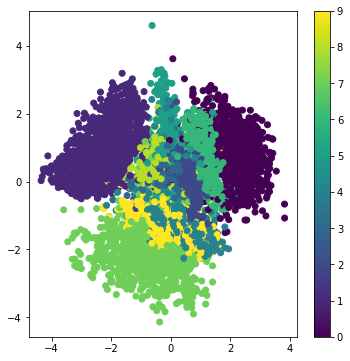

In [25]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [26]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

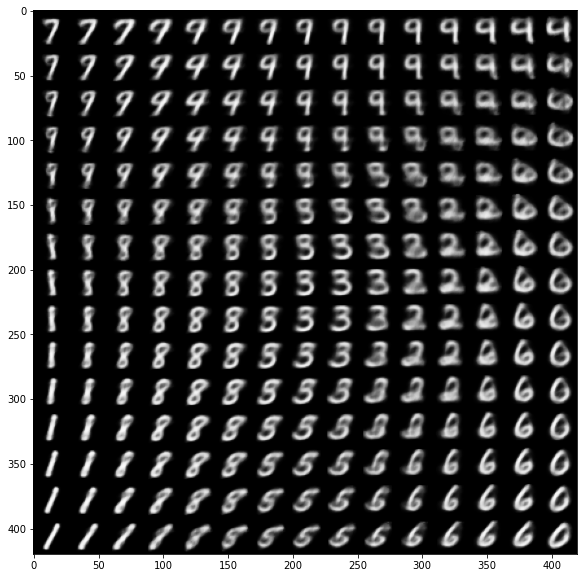

In [27]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

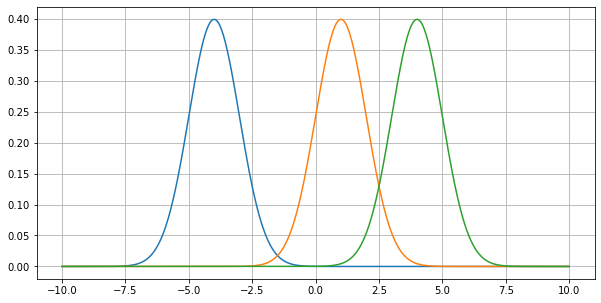

<Figure size 432x288 with 0 Axes>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .001 steps.
plt.figure(figsize=(10,5))
x_axis = np.arange(-10, 10, 0.001)
Mean1 = -4
SD1 = 1.
plt.plot(x_axis, norm.pdf(x_axis,Mean1,SD1))
Mean2 = 1
SD2 = 1.
plt.plot(x_axis, norm.pdf(x_axis,Mean2,SD2))
Mean3 = 4
SD3 = 1.
plt.plot(x_axis, norm.pdf(x_axis,Mean3,SD3))
plt.grid(True)
plt.show()
plt.savefig('mixtureOfgaussians0.png')